In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "nIPC" => ["Radial Glia-like", "Neuroblast"],
    "Radial Glia-like" => "Astrocytes",
    "Neuroblast" => ["Granule immature", "Mossy"],
    "Mossy" => "Cck-Tox",
    "Granule immature" => "Granule mature"
)

Dict{String, Any} with 5 entries:
  "Granule immature" => "Granule mature"
  "nIPC"             => ["Radial Glia-like", "Neuroblast"]
  "Neuroblast"       => ["Granule immature", "Mossy"]
  "Radial Glia-like" => "Astrocytes"
  "Mossy"            => "Cck-Tox"

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 2564 ✕ 2000

In [8]:
intrinsic_labels = sort(unique(julovelo_adata.obs.clusters))

8-element Vector{String}:
 "Astrocytes"
 "Cck-Tox"
 "Granule immature"
 "Granule mature"
 "Mossy"
 "Neuroblast"
 "Radial Glia-like"
 "nIPC"

In [9]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

5-element Vector{String}:
 "Granule immature"
 "Mossy"
 "Neuroblast"
 "Radial Glia-like"
 "nIPC"

In [10]:
intrinsic_palettes = Dict(
    "Astrocytes"=>"#3ba458",
    "Cck-Tox"=>"#7a7a7a",
    "Granule immature"=>"#2575b7",
    "Granule mature"=>"#08306b",
    "Mossy"=>"#e5d8bd",
    "Neuroblast"=>"#79b5d9",
    "Radial Glia-like"=>"#98d594",
    "nIPC"=>"#d0e1f2"
)

Dict{String, String} with 8 entries:
  "Cck-Tox"          => "#7a7a7a"
  "Astrocytes"       => "#3ba458"
  "Granule immature" => "#2575b7"
  "Granule mature"   => "#08306b"
  "nIPC"             => "#d0e1f2"
  "Neuroblast"       => "#79b5d9"
  "Mossy"            => "#e5d8bd"
  "Radial Glia-like" => "#98d594"

In [11]:
extrinsic_palettes = Dict(
    "Granule immature"=>"#2575b7",
    "Mossy"=>"#e5d8bd",
    "Neuroblast"=>"#79b5d9",
    "Radial Glia-like"=>"#98d594",
    "nIPC"=>"#d0e1f2"
)

Dict{String, String} with 5 entries:
  "Granule immature" => "#2575b7"
  "nIPC"             => "#d0e1f2"
  "Neuroblast"       => "#79b5d9"
  "Mossy"            => "#e5d8bd"
  "Radial Glia-like" => "#98d594"

In [12]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [13]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [14]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; n_neighbors = 10)
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr", n_neighbors = 10)

Dict{String, Vector{Float32}} with 8 entries:
  "Cck-Tox"          => [0.490334, 0.522646, 0.860557, 0.994999, 0.995364, 0.60…
  "Astrocytes"       => [0.769548, 0.976618, 0.546515, 0.741133, 0.694227, 0.74…
  "Granule immature" => [0.811686, 0.505357, 0.36687, 0.59908, 0.350377, 0.5886…
  "Granule mature"   => [0.367909, -0.823466, 0.28103, -0.594671, 0.302942, 0.4…
  "nIPC"             => []
  "Neuroblast"       => [-0.719834, 0.84912, 0.954473, 0.984761, 0.55121, -0.76…
  "Mossy"            => [0.711173, 0.761701, 0.667464, 0.918738, 0.987303, 0.88…
  "Radial Glia-like" => [0.231159, 0.885531, 0.795005, 0.924087, 0.681024, 0.89…

In [15]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[0.59905803, 0.18498152, 0.5189004, 0.41141337, -0.048857376, -0.4663046, 0.91508746, 0.94242895, 0.74653625, 0.044744823  …  0.9718229, 0.9534388, 0.9947988, 0.97321117, 0.9886143, 0.9934597, 0.99592936, 0.9943466, 0.9971941, 0.9915505], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo"], Any["Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

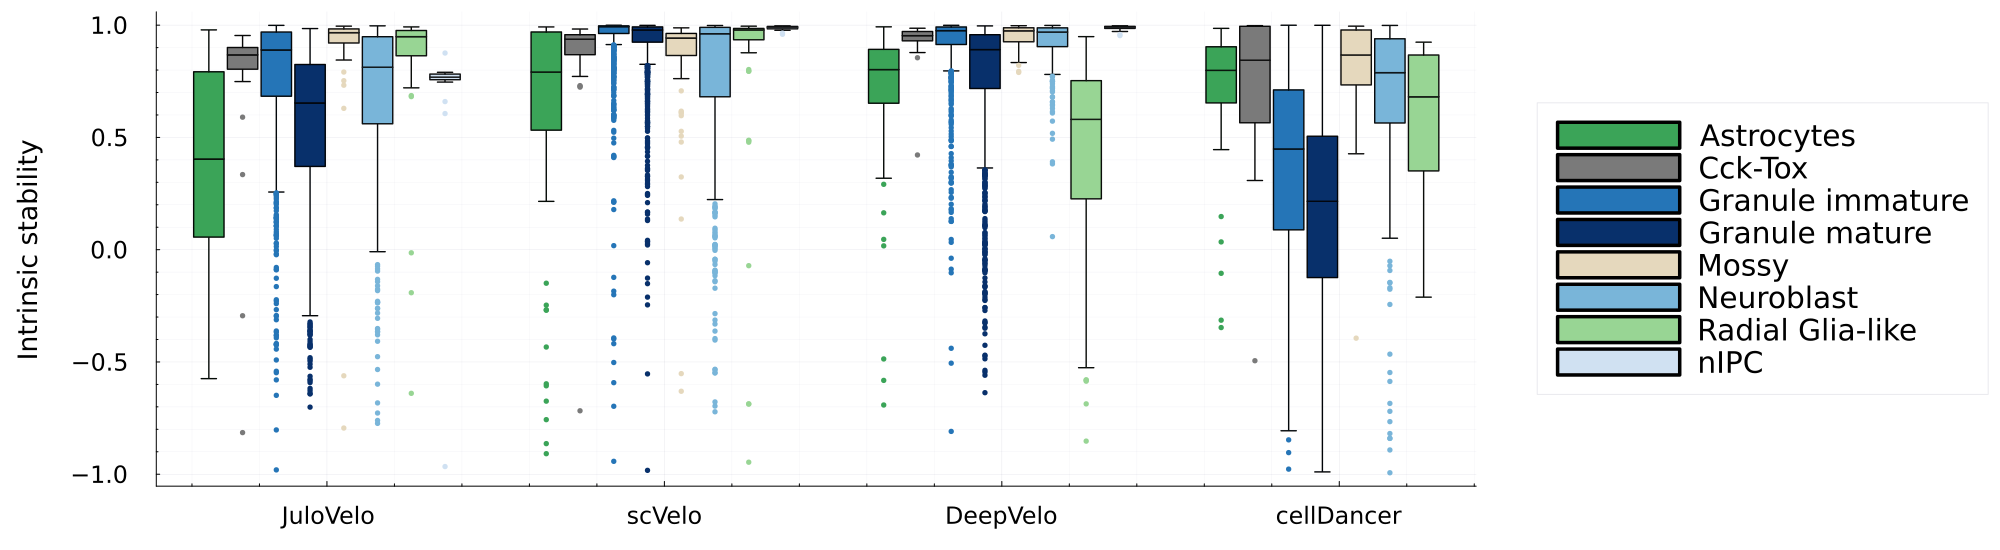

In [16]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [17]:
savefig(p, "figure/dentategyrus_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/dentategyrus/main_branch/figure/dentategyrus_intrinsic_stability.png"

# Extrinsic stability

In [18]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; n_neighbors = 10)
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr", n_neighbors = 10)

Dict{String, Vector{Float32}} with 5 entries:
  "Granule immature" => [-0.351942, -0.348217, -0.133129, -0.328409, 0.186355, …
  "nIPC"             => []
  "Neuroblast"       => [-0.743776, -0.32206, 0.998421, -0.834154, 0.161112, -0…
  "Radial Glia-like" => [-0.0176856, 0.566369, -0.0421668]
  "Mossy"            => []

In [19]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[0.43549556, -0.4502869, 0.93754774, -0.0019652806, -0.032815166, -0.09638382, -0.30169204, -0.017352074, 0.016950922, 0.24408908  …  0.9792308, -0.99599326, -0.9993348, 0.9964214, 0.80018073, 0.93094563, 0.124435425, 0.99379665, -0.994289, 0.99897057], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo"], Any["Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

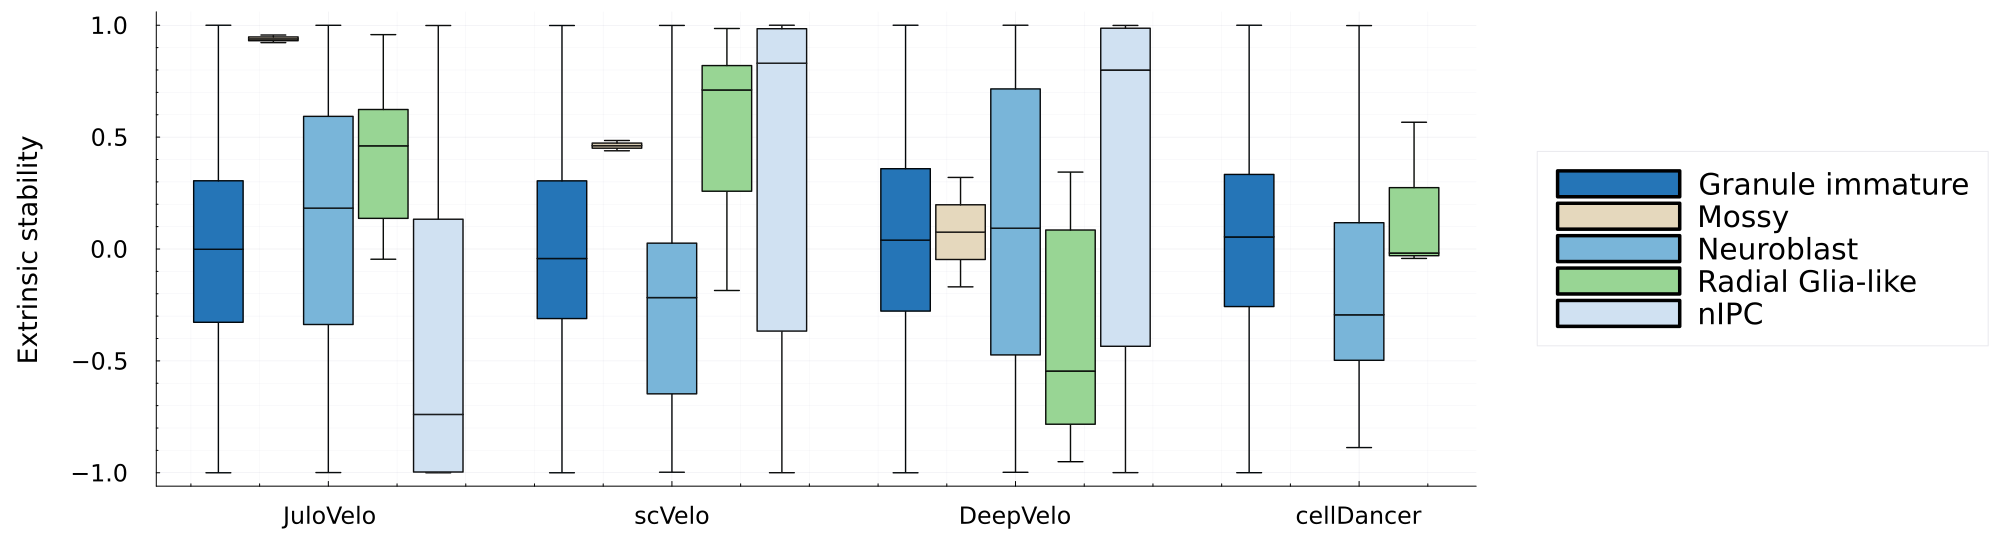

In [20]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [21]:
savefig(p, "figure/dentategyrus_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/dentategyrus/main_branch/figure/dentategyrus_extrinsic_stability.png"